# A small model on degrees of separation

A small model inspired by this tweet by Andrew Trask: https://twitter.com/iamtrask/status/1233815704543080448

    So most folks have heard of 5/6-degrees of separation
    In theory, every two people on earth are connected by roughly 5-6 relationships
    But that's for a *whole* life of interactions!!!
    I wonder what it is for 2 days of interactions, or 7 days of interactions? 
    Does anyone know?

Below, I'm trying to model this situation explicitly, with 3 different scenarios of how a kid may be integrated in the society.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

In [3]:
n_people = 300
min_degree = 20

def make_net(n=10,mindeg=1):
    """Preferential attachment algorithm."""
    if n<2: return ('Cannot do less than 3 nodes.')
    net = {0:[1], 1:[0]}
    ends = [0,1]
    for i in range(2,n):
        j = rnd.choice(ends)
        net[i] = [j]
        net[j].append(i)
        ends = ends + [i,j]
    for i in range(n): # Guaranteed degree
        if len(net[i])<mindeg:
            for k in range(mindeg-len(net[i])):
                j = rnd.choice(ends)
                if j not in net[i]: net[i].append(j)
                if i not in net[j]: net[j].append(i)
    return net
        
net = make_net(n_people,min_degree)
if n_people<10:
    print(net)

In [4]:
# The distribution of degrees of separation

def bfs(net,deg,root,target):
    """Do breadth-first search to find shortest connection from i to j."""
    if root==target: return
    q = net[root].copy()
    visited = [0]*len(net)
    visited[root] = 1
    depth = 0
    while len(q)>0:
        depth += 1
        for k in range(len(q)):
            i = q.pop(0) # Queue, not stack, so pop from 0
            deg[root,i] = depth
            deg[i,root] = depth
            visited[i] = 1
            if i==target: return
            q = q+[j for j in net[i] if not visited[j]]

def degrees(net):
    """Return a matrix of degrees of separation."""
    n = len(net)
    deg = np.zeros((n,n))
    for i in range(1,len(deg)):
        print('.',end='')
        if i % 100 == 0: print()
        for j in range(i):
            if deg[i,j]==0:
                bfs(net,deg,i,j) # Breadth-first-search. Probably not too efficient, but oh well.
    return deg

# Calculate
deg = degrees(net)
print('Done')
if n_people<10:
    print(deg)

....................................................................................................
....................................................................................................
...................................................................................................Done


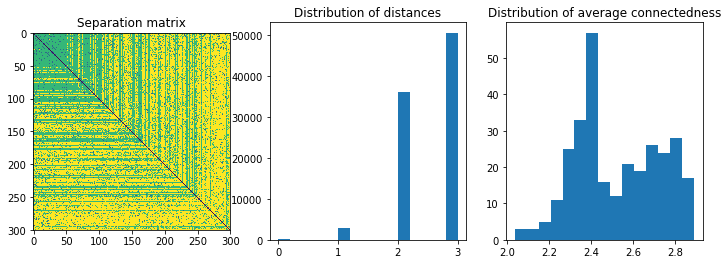

In [5]:
# Visualize
plt.figure(figsize=(12,4))
plt.subplot(131);
plt.imshow(deg);
plt.title('Separation matrix')

plt.subplot(132);
plt.hist(deg.flatten(), bins=15);
plt.title('Distribution of distances');

plt.subplot(133);
plt.hist(np.mean(deg,axis=0), bins=15);
plt.title('Distribution of average connectedness');

Now let's model ways in which a child may be introduced to a society. I can think of three basic approaches here:

1. Patriarchal society: the kid only gets to know their parent's friends.
2. Dystopia: the kid is raised by the state and gets to know people randomly
3. Meritocracy: at each point the kid randomly knows a friend of their existing friends

To keep modeling simpler, at each step I will place the kid at node 0 (killing the previous inhabitant of node 0), but the parent will be selected at random.

Mean degree: 26
Patriarchal
..........
Dystopian
..........
Realistic
..........


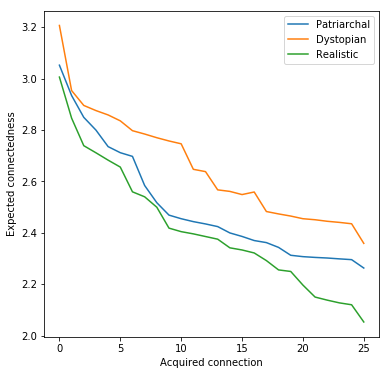

In [7]:
n_trials = 10
mean_deg = int(np.ceil(np.mean([len(v) for k,v in net.items()])))
print('Mean degree:',mean_deg)

def kill(net,deg,i):
    """Remove this individual."""
    for j in range(len(net)):
        if j!=i:
            if i in net[j]:
                net[j].remove(i)
        net[i] = []
        deg[i,:] = 0
        deg[:,i] = 0
        
plt.figure(figsize=(6,6));
plt.xlabel('Acquired connection');
plt.ylabel('Expected connectedness');

# Destiny of a child:
for world in ['Patriarchal','Dystopian','Realistic']:
    print(world)
    history = np.zeros((mean_deg,n_trials))
    for i_trial in range(n_trials):
        print('.',end='')
        kill(net,deg,0)
        parent = rnd.randint(0,n_people-1)
        pool = net[parent].copy()
        count = 0
        while len(pool)>0 and count<mean_deg: # Let this kid aquire at most average number of connections
            new_con = rnd.choice(pool)
            pool.remove(new_con)
            net[new_con].append(0)
            net[0].append(new_con)
            deg[0,:] = 0            # Clean current distances for person 0
            deg[:,0] = 0
            for j in range(1,len(net)):
                bfs(net,deg,0,j)    # Assume that person 0 doesn't affect other distances too much
            history[count,i_trial] = np.mean(deg[0,:])
            
            if world=='Dystopian':
                pool = [rnd.randint(0,n_people-1)] # Next random person
            if world=='Realistic':
                pool = pool + [t for t in net[j] if t not in pool and t not in net[0]]
                # Include all connections of this new friend
            count += 1
        if count<mean_deg:
            history[count:,i_trial] = history[count-1,i_trial]
    print()            
    plt.plot(np.mean(history, axis=1), label=world);

plt.legend(loc='upper right');

**Conclusion**: As expected, newborns start about 1 degree of separation further than everyone else (as originally they are only connected to their parent), and then gradually "relax" to the mean. 

The dynamics of this relaxation doesn't depend that much on the way they are introduced to the society: either way, they sample from a power-skewed distribution of degrees. There are however some differences.

"Dystopian" approach leads to the least connected child, as it samples people randomly, and thus draws many people who are poorly connected. "Patriarchal" approach is better, as the parent is more likely to be connected to well-connected people (in accordance with the famous paradox that your friends have more friends than you do). "Exploration", however, is the best one, as it further amplifies this effect (not only your parents are more likely to be connected to influencers, but also always picking a friend out of friends of your friends, you are even further likely to hit an influencer).